# Stablization via Symmetrization


We've seen how we can implement the "symmetrized tensor product" of several qubits in terms of a quantum circuit: depending on the number of qubits we want to symmetrize, we adjoint a number of auxilliary qubits, prepare them in a special initial state, apply a sequence of controlled swaps on the auxilliaries and the original qubits, undo the initialization, and postselect on the auxilliary qubits all being $0/\uparrow$. The key was that the algorithm requires post-selection, and so is only successful part of the time. By preparing our original qubits in the directions provided by a constellation of "Majorana stars", we were thus able to prepare spin-$j$ states in the guise of $2j$ symmetrized qubits. 

But nothing limits us to symmetrizing qubits. In fact, we can apply the same algorithm to symmetrize quantum systems consisting of several qubits: we simply repeat the controlled swaps on however many qubits comprise each subsystem. In fact, this played a role in the motivation behind the paper which provided our symmetrization algorithm: "Stabilization Of Quantum Computations by Symmetrization".

The idea is the following: Suppose we have a quantum computer, and we're worried about noise. Instead of just running our quantum circuit, we could run $n$ copies of the circuit in parallel, while periodically using the symmetrization algorithm to project the $n$ copies as a whole into the permutation symmetric subspace. Suppose there were no errors: then naturally, each copy of the circuit would be precisely the same, and symmetrizing across them would have no effect. But if there are some errors that asymmetrically affect the different copies, then it's possible that projecting the copies into the permutation symmetric subspace will project off these errors! Indeed, the permutation symmetric subspace "is the smallest subspace containing all possible error-free states. It thus corresponds to the 'most probing' test we can legitimately apply, which will be passed by all error-free states," since we can't just do any probe we like, since such poking around will generally disturb the quantum computation. Moreover, if we rapidly and periodically do this projection, which is probabilistic, then due to the "quantum Zeno effect," we should be able to stay within the subspace with high probability.

The problem, however, is that to do the symmetrization at all, we need to add in extra qubits and perform highly entangling operations, again and again. Given that NISQ-era quantum computers are notoriously unreliable about things like controlled swap operations, one might wonder if the errors introduced by the symmetrization algorithm itself would outweight the errors corrected by symmetrization! And in fact, that sadly seems to be the case--for now!

But with an eye to the future, let's check out how it might work. 

(Incidentally, depending on one's particular quantum circuit, there may be other relevant subspaces that one could project into, without disturbing the computation, and which would provide some much needed stabliziation. The "stabilization via symmetrization" technique, however is nice insofar as it can help independently of the structure of one's circuits. Indeed, if such stabilization could be provided by the quantum computer itself that would be ideal.)

<hr>

Let's start off with a simple random circuit consisting of two qubits and two layers of gates. Note that we're using the library `pytket` for our circuits. `random_pytket_circuit` returns a dictionary specifying the circuit (for easy manipulation), and requires `build_pytket_circuit` to actually construct the circuit.

In [1]:
from spheres import *

n_qubits = 2
depth = 2

circ_info = random_pytket_circuit(n_qubits=n_qubits, depth=depth)
circ = build_pytket_circuit(circ_info)

<IPython.core.display.Javascript object>

The resulting circuit will look something like this (the image below was pregenerated, since `pytket` won't display its latex output to jupyter notebooks):

<img src="img/circ_tex.png">

Each layer consists of some single qubit gates and a CNOT.

In [2]:
sym_circ_info = symmetrize_pytket_circuit(circ_info,
                                          n_copies=2,
                                          every=1, 
                                          pairwise=False)
sym_circ = sym_circ_info["circuit"]

The symmetrized circuit might look something like this: 

<img src="img/sym_circ_tex.png">

We have two copies of the circuit running in parallel, and we do symmetrization after each of the two layers.

First, let's evaluate the original circuit analytically to see what the answers should be.

In [4]:
basis = list(product([0,1], repeat=n_qubits))
def display_dist(dist):
    global basis
    for bitstr in basis:
        val = dist[bitstr] if bitstr in dist else 0
        print("  %s: %f" % ("".join([str(b) for b in bitstr]), val))

circ_dist = eval_pytket_circuit_ibm(circ, analytic=True)
print("analytical dist for original circuit:")
display_dist(circ_dist)

analytical dist for original circuit:
  00: 0.500000
  01: 0.000000
  10: 0.500000
  11: 0.000000


Now let's add in some noise. We can choose between `thermal_noise_model`, `bitflip_noise_model` and `ibmq_16_melbourne_noise_model` model, or add in a new one!

In [6]:
circ_noise_model = thermal_noise_model(n_qubits=n_qubits, on_qubits=list(range(n_qubits)))
noisy_circ_counts = eval_pytket_circuit_ibm(circ.copy().measure_all(), noise_model=circ_noise_model)
noisy_circ_dist = probs_from_counts(noisy_circ_counts)

print("noisy dist for original circuit:")
display_dist(noisy_circ_dist)

noisy dist for original circuit:
  00: 0.512625
  01: 0.002875
  10: 0.482500
  11: 0.002000


We could try to do error mitigation:

In [7]:
circ_meas_filter = qiskit_error_calibration(n_qubits, circ_noise_model)    
mitigated_circ_dist = probs_from_counts(qiskit_pytket_counts(circ_meas_filter.apply(pytket_qiskit_counts(noisy_circ_counts))))

print("mitigated dist for original circuit:")
display_dist(mitigated_circ_dist)

mitigated dist for original circuit:
  00: 0.504593
  01: 0.002901
  10: 0.490434
  11: 0.002073


Now let's look at the symmetrized circuit. We evaluate the circuit, do the postselection, and average the results across the copies. Here we haven't included any noise, so this won't be any different from simply running the original circuit with a higher number of shots.

In [8]:
def display_sym_dists(sym_dists):
    global basis
    exp_dists, avg_dist = sym_dists["exp_dists"], sym_dists["avg_dist"], 
    print("  postselected dists:")
    for i, dist in enumerate(exp_dists):
        print("    circuit %d:" % i)
        for bitstr in basis:
            print("      %s: %f" % ("".join([str(b) for b in bitstr]), dist[bitstr])) if bitstr in dist else None
    print("  averaged dists:")
    for bitstr in basis:
        print("    %s: %f" % ("".join([str(b) for b in bitstr]), avg_dist[bitstr])) if bitstr in avg_dist else None
        
clean_sym_circ_counts = eval_pytket_circuit_ibm(sym_circ)

print("clean sym circ dists:")
display_sym_dists(process_symmetrized_pytket_counts(sym_circ_info, clean_sym_circ_counts))

clean sym circ dists:
  postselected dists:
    circuit 0:
      00: 0.502000
      10: 0.498000
    circuit 1:
      00: 0.514375
      10: 0.485625
  averaged dists:
    00: 0.508188
    10: 0.491812


Now let's look at the performance of the symmetrized circuits with some noise.

In [9]:
sym_circ_noise_model = thermal_noise_model(n_qubits=len(sym_circ.qubits), on_qubits=list(range(len(sym_circ.qubits))))
noisy_sym_circ_counts = eval_pytket_circuit_ibm(sym_circ, noise_model=sym_circ_noise_model)

print("noisy sym circ dists:")
noisy_sym_circ_dists = process_symmetrized_pytket_counts(sym_circ_info, noisy_sym_circ_counts)
display_sym_dists(noisy_sym_circ_dists)

noisy sym circ dists:
  postselected dists:
    circuit 0:
      00: 0.506192
      01: 0.015902
      10: 0.460597
      11: 0.017309
    circuit 1:
      00: 0.506192
      01: 0.020124
      10: 0.458204
      11: 0.015480
  averaged dists:
    00: 0.506192
    01: 0.018013
    10: 0.459401
    11: 0.016395


We could try doing error mitigation:

In [10]:
sym_circ_meas_filter = qiskit_error_calibration(len(sym_circ.qubits), sym_circ_noise_model)    
mitigated_sym_circ_counts = qiskit_pytket_counts(sym_circ_meas_filter.apply(pytket_qiskit_counts(noisy_sym_circ_counts)))
mitigated_sym_circ_dists = process_symmetrized_pytket_counts(sym_circ_info, mitigated_sym_circ_counts)

print("mitigated sym circ dists:")
display_sym_dists(mitigated_sym_circ_dists)

mitigated sym circ dists:
  postselected dists:
    circuit 0:
      00: 0.494203
      01: 0.015483
      10: 0.472539
      11: 0.017775
    circuit 1:
      00: 0.498741
      01: 0.020111
      10: 0.465265
      11: 0.015883
  averaged dists:
    00: 0.496472
    01: 0.017797
    10: 0.468902
    11: 0.016829


And now let's look at how well we did.

In [12]:
expected_probs = np.array([circ_dist[b] if b in circ_dist else 0 for b in basis])
actual_circ_probs = np.array([mitigated_circ_dist[b] if b in mitigated_circ_dist else 0 for b in basis])
actual_sym_circ_probs = np.array([mitigated_sym_circ_dists["avg_dist"][b] if b in mitigated_sym_circ_dists["avg_dist"] else 0 for b in basis])

print("expected results: %s" % expected_probs)
print("actual circ results: %s" % actual_circ_probs)
print("actual sym_circ results: %s" % actual_sym_circ_probs)
print()
print("circ error: %f" % np.linalg.norm(np.array(actual_circ_probs) - np.array(expected_probs)))
print("sym circ error: %f" % np.linalg.norm(np.array(actual_sym_circ_probs) - np.array(expected_probs)))

expected results: [0.5 0.  0.5 0. ]
actual circ results: [0.50459295 0.00290095 0.49043356 0.00207255]
actual sym_circ results: [0.496472   0.01779701 0.46890165 0.01682934]

circ error: 0.011195
sym circ error: 0.039743


To get a better sense of under what conditions the algorithm might be helpful, we can easily run experiments in batches. For example, below we evaluate circuits with two qubits, with two copies to symmetrize over, where we symmetrize every two layers, randomly pairwise instead of across all the circuits, with thermal noise, and where the errors apply to auxilliary qubits as much as the other qubits. We evaluate such circuits for depths from $1$ to $8$, averaging over many randomly generated circuits for each depth, and graph the results (we could have chosen another parameter to vary, besides depth)!

depth: 1
depth: 2
depth: 3
depth: 4


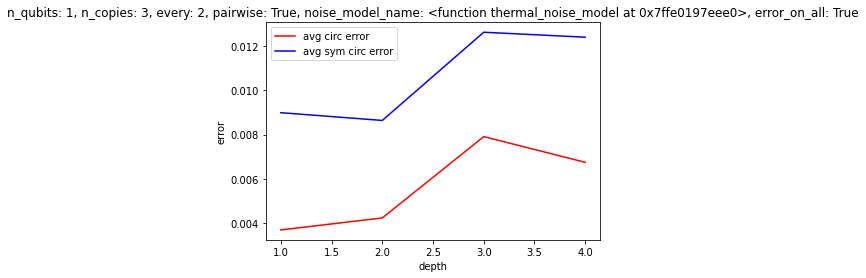

In [29]:
from spheres import *

params = {"n_qubits": 1,\
          #"depth": 2,\
          "n_copies": 3,\
          "every": 2,\
          "pairwise": True,\
          "noise_model": thermal_noise_model,\
          "noise_model_name": thermal_noise_model,\
          "error_on_all": True,\
          "backend": Aer.get_backend("qasm_simulator"),\
          "shots": 8000}

depths = list(range(1, 5))
n_runs = 50
experiments = []
for depth in depths:
    print("depth: %d" % depth )
    circ_errors, sym_circ_errors = [], []
    for i in range(n_runs):
        experiment = eval_pytket_symmetrization_performance(**params, depth=depth)
        circ_errors.append(experiment["circ_error"])
        sym_circ_errors.append(experiment["sym_circ_error"])
    experiments.append({**params, **{"depth": depth,\
                                     "circ_error": sum(circ_errors)/len(circ_errors),\
                                     "sym_circ_error": sum(sym_circ_errors)/len(sym_circ_errors)}})

plot_symmetrization_performance("depth", experiments)

Some results, picked somewhat arbitrarily:

![result1](img/sym_circ_result1.png)

![result2](img/sym_circ_result2.png)

![result3](img/sym_circ_result3.png)

![result4](img/sym_circ_result4.png)

<img style="display:block; margin:auto" src="img/sym_circ_result5.png" width=450>

<hr>

Clearly, it's not a given that this method of "stablization" will deliver results at least at the moment. It would be interesting to find some set of conditions that would make this algorithm relevant. The difficulties are, of course, errors in the symmetrization procedure itself, and also the scaling of the auxilliary qubits. Unless intermediate measurements are possible, allowing one to reuse auxilliary qubits, the cost of applying the algorithm quickly becomes prohibitive--and there aren't enough gains at the small scale, it seems, to make it worth using. In the future, however, one could imagine having thousands of qubits, as well as reliable CSWAP gates, so that one could reliably symmetrize over hundreds copies of the circuit, etc. See the attached papers for some discussion of the types of errors that this method is best at dealing with.

<hr>

## Bibliography 

[Error Symmetrization in Quantum Computers](https://arxiv.org/abs/quant-ph/9611046)

[Stabilization of Quantum Computations By Symmetrization](https://heyredhat.github.io/refs/Stabilization_of_Quantum_Compu.pdf)